In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1: s for i,s in enumerate(chars)}
itos[0] = '.'

In [217]:
# build the dataset
block_size = 16 # context length
def build_dataset(words):
    X, Y = [], []
    
    for word in words:
        #print(word)
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print("".join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182534, 16]) torch.Size([182534])
torch.Size([22873, 16]) torch.Size([22873])
torch.Size([22739, 16]) torch.Size([22739])


In [129]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", "".join(itos[y.item()]))
    

........ --> e
.......e --> m
......em --> e
.....eme --> r
....emer --> s
...emers --> e
..emerse --> n
.emersen --> .
........ --> m
.......m --> e
......me --> l
.....mel --> i
....meli --> n
...melin --> n
..melinn --> a
.melinna --> .
........ --> l
.......l --> a
......la --> m
.....lam --> i


In [154]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out =  x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            if(x.dim() == 2):
                dim = 0
            elif(x.dim() == 3):
                dim = (0,1)
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        # normalize
        x_hat = (x - x_mean)/torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, XI):
        self.out = self.weight[XI]
        return self.out
    def parameters(self):
        return [self.weight]

# FLattens n consecutive elements
class FlattenConsecutive: 
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B,T//self.n, C*self.n) # C is n_embed (e.g 10). so if we want 2 consecutive elements then it will result in a 10*2 tensor
        if(x.shape[1] == 1):
            x = x.squeeze(1) # Squeeze in pytorch to get rid of dimension if 1. will return (B, C*n) tensor instead of (B, 1, C*n)
        self.out = x
        return self.out

    def parameters(self):
        return []
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [155]:
torch.manual_seed(42);

In [220]:
n_embd = 24 # the dimensionality of the characted embedding vectors
n_hidden = 128 # hidden layers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(stoi)
n_consecutive = 2

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(n_consecutive),Linear(n_embd * n_consecutive, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_consecutive),Linear(n_hidden * n_consecutive, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_consecutive),Linear(n_hidden * n_consecutive, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive),Linear(n_hidden * n_consecutive, n_hidden, bias=False),BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

109603


In [221]:
# for wavenet we want to view the tensor differently, for wavenet we fuse two inputs each time into the text layer
# for example,instead of (4,80) tensor we want (4, 4, 20) tensor. We add another batch dimention of 4. (80 because 8 exapmles x 10 (n_embed))
ix = torch.randint(0,Xtr.shape[0],(4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 16])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 19,  8, 20],
        [ 0,  0,  0,  0,  0,  0,  0, 19, 15, 16,  8,  9,  1,  7, 18,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2, 18]])

In [158]:
model.layers[3].out.shape

torch.Size([4, 4, 68])

In [160]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [140]:
torch.randn(1,2,3).dim()

3

In [222]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 16, 24)
FlattenConsecutive : (4, 8, 48)
Linear : (4, 8, 128)
BatchNorm1d : (4, 8, 128)
Tanh : (4, 8, 128)
FlattenConsecutive : (4, 4, 256)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [ ]:
# Same training as before
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.05 if i < 150000 else 0.005 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()+1e-5).log10().item() for p in parameters])
  #if i >= 1000:
    #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3072
  10000/ 200000: 2.0314


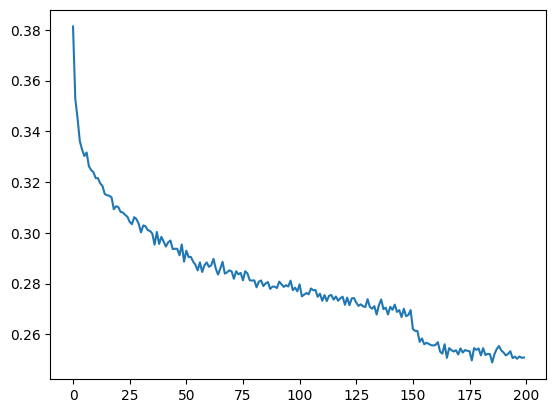

In [189]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [200]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

ValueError: Expected input batch_size (1) to match target batch_size (182661).

## Log

- context size 3 char (estimated from before)
train 2.x
val 2.1


- context size 8 char (22k params), train 1.923, val 2.029

- wavenet 8 context length 22k params, train: 1.946, val: 2.034

- wavenet 8 context length 22k params fixed batch norm, train: 1.91, val: 2.009

- wavenett 16 context length 32k params: train: 1.873, val: 1.995
- wavenett 16 context length 200 hidden units 251k params: train: 1.628, val: 2.032 looks like we are overfitting badly
- wavenett 8 context length 128 hidden units 24 n_embed 76k params 1.761, val: 1.997
- wavenett 16 context length 128 hidden units 24 n_embed 109k params


In [204]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decord and print generated word 

RuntimeError: prob_dist must be 1 or 2 dim